# PIC 16B Final Project
### By:  Artem Kiryukhin and Karl Puttler

For this project we plan to use a dataset of 87,000 images of various American Sign Language hand signs to train a model which could accurately translate the hand signs to their appropriate meanings.
TODO: EXPAND THIS

Below we import the necessary libraries

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from IPython.display import Image as Img
from sklearn.metrics import confusion_matrix
import seaborn as sns

from dataProcessing import train_loader, test_loader, fraction_loader
from models import LeNet5

Since we wanted to work with our trained model and not necessarily train a new one every single time we worked in this file we implemented simple lambda functions to handle saving and loading the model parameters.

In [2]:
# save and load model functions
save_model = lambda model,name: torch.save(model.state_dict(),name)
load_model = lambda model,name: model.load_state_dict(torch.load(name))
MODEL_PATH = "ImageRecognitionModel.pth"

### Visualizing the Processed Images
The code below loads one batch from the train_loader object we defined in the dataProcessing file of this project. This object is created using the DataLoader class from PyTorch. Thanks to this class we do not need to worry about manually shuffling, batching, and loading the data. In addition to loading a single batch we define a list of label names to display instead of the numerical labels that the data has right now. Finally we itterate through a couple of samples and display the images that we will be inputting into our model. Notice the strange colors, these are due to standardization we performed on the pixel values of the images.

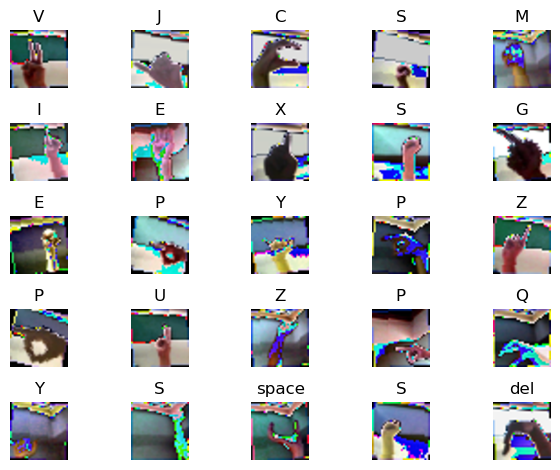

In [4]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])


# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()

### Training and Accuracy Functions

Below are the functions we created for getting the accuracy of our model and to actually train the model. Let's walk through the inner mechanisms of each. 

The evaluate() function works by calculating how predictions are equal to the true label of the image for each batch, in other words how many did the model predict right. Then it simply divides this number by the amount of images are in the data set, multiplies it by a 100, and voila there is the model's accuracy.  Additionally this also gets the average loss function value per batch. We get the average since the train dataset has more batches and hence a cumulative function will produce artificially large loss values for the train data. Important note to use torch.no_grad() in order to make sure that none of our calculation interfere with gradient values later on.

The train model is slightly more complex, though it is nothing out of the ordinary. During the function runtime we unpack each batch into image pixels and labels, next we get the prediction of the current model and use those to calculate the loss. For the loss function we use CrossEntropyLoss which is standard for multi-class classification problems like we have here. After we get the loss we calculate the gradients with respect to each weight by calling loss.backward() and then perform an update rule via the optimizer class. 

In [11]:
def evaluate(model,test_loader):
    """ Tests the model's accuracy """
    
    #sets model to eval mode
    model.eval()
    correct = 0
    test_loss = 0
    total_samples = 0
    
    with torch.no_grad():
    
        for data, label in test_loader:
            
            # model's prediction
            output = model(data)
            
            # Calculate the number of correct responses in current batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            test_loss += loss_criteria(output, label).item()
            total_samples += data.size(0)
            
    test_loss = test_loss / total_samples
    
    accuracy = round((100 * correct / len(test_loader.dataset)),2)
    
    return (accuracy, test_loss)

In [12]:
def train(model, train_loader,test_loader, optimizer, loss_criteria, epoch):
    """ Trains the model parameters and returns loss and
    accuracy at each epoch
    
    Args:
    model - pytorch model to train
    train_loader - dataLoader object w/ training data
    test_loader - dataLoader object w/ testing data
    optimizer - pytorch optimizer object
    loss_criteria - pytorch loss criteria
    epoch - what the current epoch is
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data,label in train_loader_iter:

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        
        # calculates gradient
        loss.backward()
        optimizer.step()
    
    train_acc,_ = evaluate(model,train_loader)
    test_acc, test_loss = evaluate(model,test_loader)
        
    return (loss_tracker,test_loss, train_acc, test_acc)   

### Defining Parameters
Below we define our learning rate, epochs, and empty lists with loss and accuracy values. Additionally we initialize the model, optimizer, and the loss function.

Through trial and error of using a subset dataset we found that the more or less default learning rate of 0.01 was actually optimal for our training. Any larger values produced gradient steps that were too large and the model would overstep the global minimum. Additionally we chose the Adam optimizer since it helps use momentum to optimize the weights quicker, something we value greatly since our resources are limited and training models for a long time is quite constraining. 

In [13]:
learning_rate = 0.01
epochs = 20
train_losses = []; test_losses = []; 
train_accuracies = []; test_accuracies = []


model = LeNet5()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss()

### Training the Model
This code simply calls the train function epoch amount of times and appends the accuracies and loss values. 

In [16]:
for epoch in range(epochs):
    train_loss,test_loss,train_accuracy,test_accuracy = train(model, fraction_loader, 
                                            test_loader, optimizer, loss_criteria, epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch 2: 100%|██████████████████████████████████| 28/28 [00:09<00:00,  3.10it/s]


KeyboardInterrupt: 

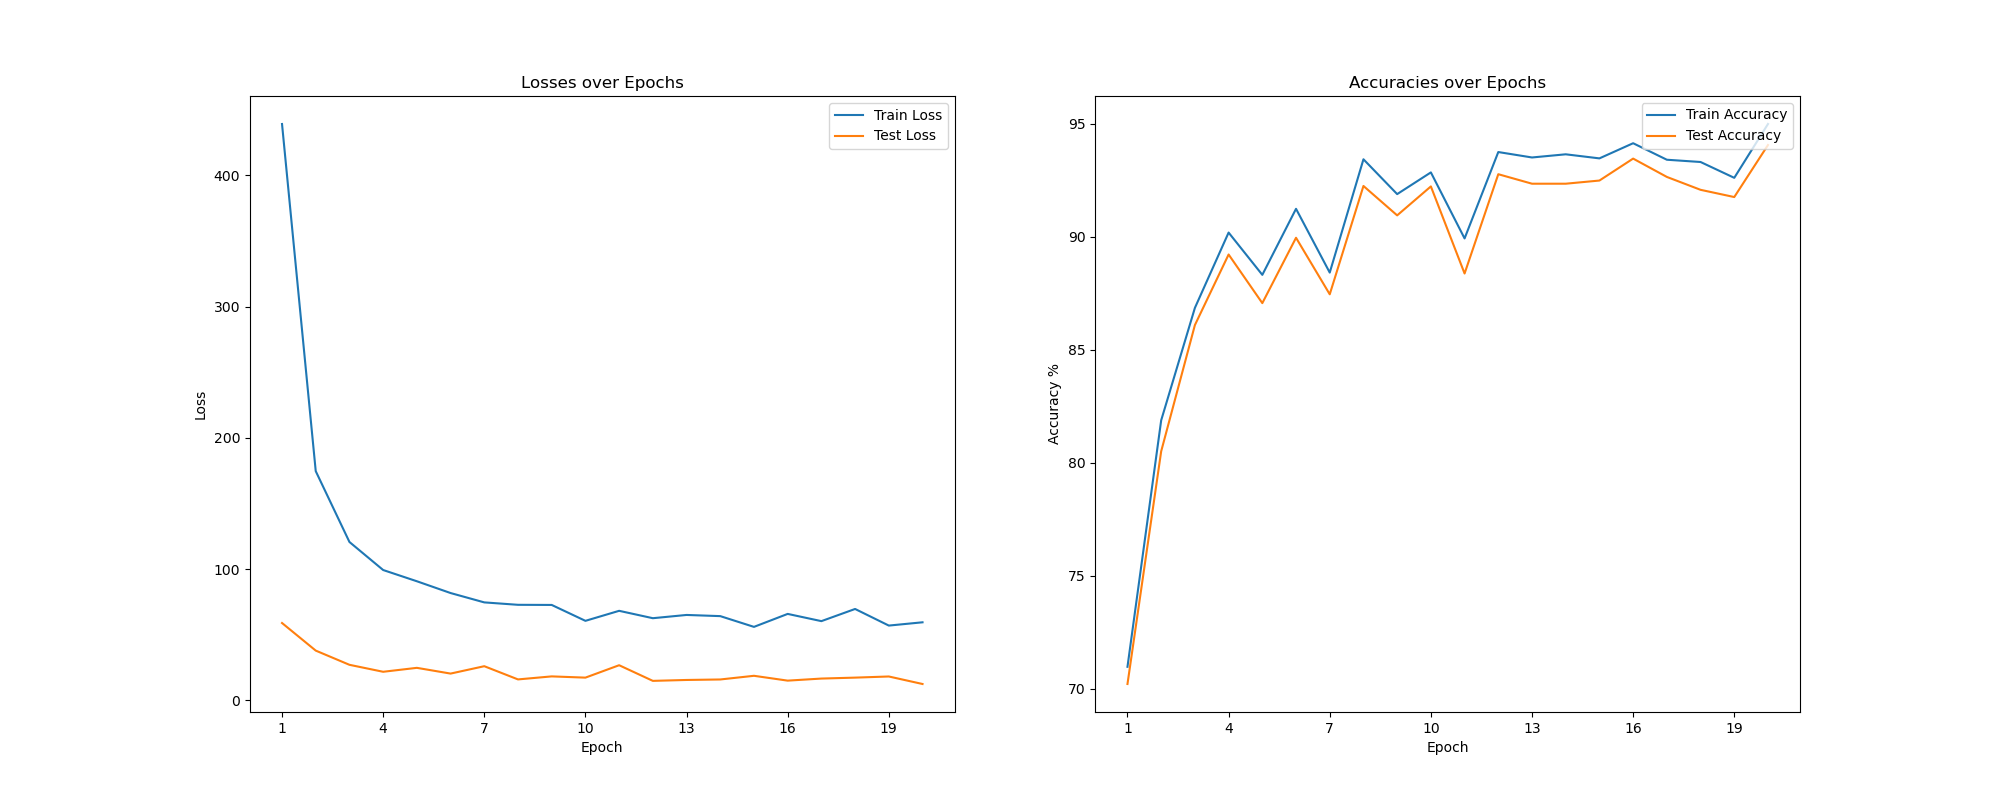

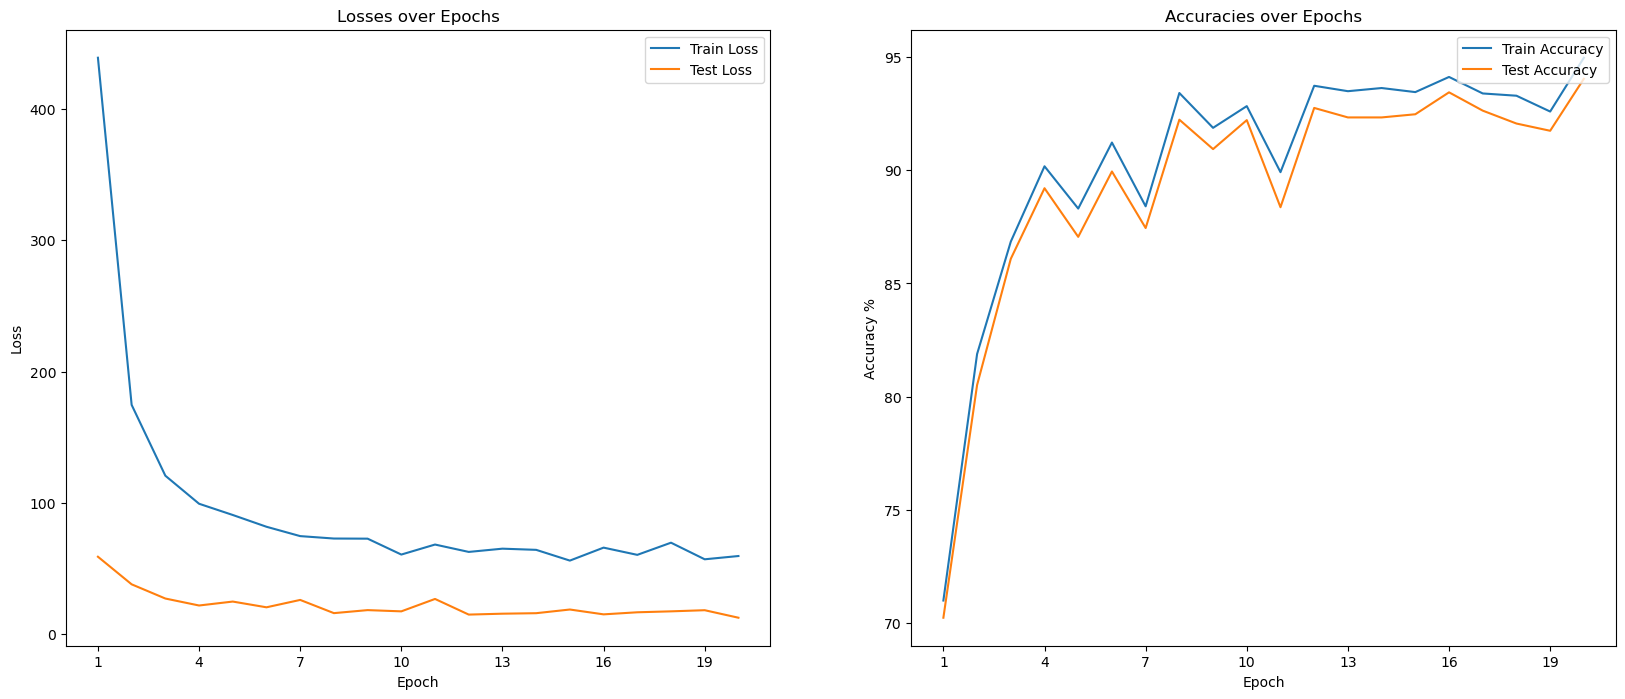

In [11]:
def make_plots(fileName):
    """ Creates a losses and accuracies plots and saves them to specified
    file name. """
    fig,ax = plt.subplots(1,2, figsize = (20,8))

    ax[0].plot(np.arange(1,epochs + 1), train_losses, label = "Train Loss")
    ax[0].plot(np.arange(1,epochs + 1), test_losses, label = "Test Loss")
    ax[0].set(title = "Losses over Epochs", ylabel = "Loss", xlabel = "Epoch")
    ax[0].set_xticks(np.arange(1,epochs+1,3));
    ax[0].legend(loc = "upper right")

    ax[1].plot(np.arange(1,epochs + 1), train_accuracies, label = "Train Accuracy")
    ax[1].plot(np.arange(1,epochs + 1), test_accuracies, label = "Test Accuracy")
    ax[1].set(title = "Accuracies over Epochs", ylabel = "Accuracy %", xlabel = "Epoch")
    ax[1].set_xticks(np.arange(1,epochs+1,3));
    ax[1].legend(loc = "upper right")

    plt.savefig(fileName, format="png")

    
PLOT_PATH = "beforeDataAugmentation.png"  

# this 
make_plots(PLOT_PATH)

# displays the plot
Img(filename= PLOT_PATH)

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

In [10]:
save_model(model, MODEL_PATH)

In [ ]:
del model

In [ ]:
model = LeNet5()
load_model(model, MODEL_PATH)

In [ ]:
print(f"The accuracy on our validation set is: {get_accuracy(model,val_loader)}%")
print(f"The accuracy on our validation set is: {get_accuracy(model,test_loader)}%")

In [ ]:
def create_confusion_matrix(model, test_loader):
    """ Creates a confusion matrix given a model and a dataLoader object"""
    
    # sets the model to eval mode
    model.eval()
    

    labels_list = []
    predicted_list = []
    
    
    with torch.no_grad():
    
        for data,label in test_loader:
            # fills the labels and predictions
            labels_list.extend(label.numpy())
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            predicted_list.extend(predicted.numpy())
            
    
    conf_matrix = confusion_matrix(labels_list, predicted_list)
    
    # creates a sns heatmap with the conf matrix
    plt.figure(figsize=(14,10))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=labels_names, yticklabels=labels_names, vmax = 100)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
            
            
create_confusion_matrix(model, test_loader)